In [1]:
import torch
import csv
from tqdm import tqdm_notebook, tqdm  # Tqdm progress bar
from torch.utils.data import random_split
from transformers import AutoTokenizer
import evaluate as e
import numpy as np

from Summarizer import Summarizer
from train_utils import dataloader, plot_curves

/Users/jenny/opt/anaconda3/envs/cs7643-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set Directory & Device

In [2]:
# Set folder path
trial = "trial_2023-04-28_13-58_lr_0.001_bs_128"
path = f"../results/{trial}/"

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Functions

In [15]:
def load_model(path, params):
    checkpoint = torch.load(path)
    model = Summarizer(input_size=params['input_size'], 
                       hidden_size=params['hidden_size'], 
                       output_size=params['output_size'], 
                       device=device, 
                       max_length = params['max_length'], 
                       num_heads=params['num_heads'], 
                       dropout=params['dropout']
                       )
    model.load_state_dict(checkpoint)
    return model

In [18]:
# Ref: translate function from A4
def summarize(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar 
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[:,0].transpose(1,0).to(device)
            target = data[:,1].transpose(1,0).to(device)

            summary = model(source, use_checkpointing=False)
            return target, summary

In [6]:
def read_result(path, columns):
    with open(path + 'result.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        result_dict = {}
        for row in csv_reader:
            for i in range(len(columns)):
                key = columns[i]
                result_dict[key] = row[key]
    return result_dict

### Load Model State Dict

In [7]:
params = ['input_size', 'hidden_size', 'output_size', 'max_length', 'num_heads', 'dropout', 'batch_size']
param_values = read_result(path, params)

for key, value in param_values.items():
    try:
        param_values[key] = int(value)
    except ValueError:
        try:
            param_values[key] = float(value)
        except ValueError:
            pass

In [16]:
# Load model state and parameters
model = load_model(path+'model_state_dict.pt', param_values)

### Test Model

In [21]:
# Load preprocessed training data
input_data = torch.load('../data/processed/tokenized_input_data_maxlen32.pt')
target_data = torch.load('../data/processed/tokenized_target_data_maxlen32.pt')
data = torch.cat((input_data, target_data), dim=1)
train_data, val_data, test_data = random_split(data, [0.8, 0.1, 0.1])

# Define data loaders
train_loader, val_loader, test_loader = dataloader(train_data, val_data, test_data, batch_size=param_values['batch_size'])

In [22]:
target, summary = summarize(model, test_loader)

  0%|          | 0/1 [00:06<?, ?it/s]


In [ ]:
# # Inspect output
# summary.argmax(dim=-1).squeeze().transpose(0,1)
# target.squeeze(dim=0).transpose(0,1)

In [24]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

decoded_summaries = []
decoded_targets = []

summaries = summary.argmax(dim=-1).squeeze().transpose(0,1).tolist()
summaries = np.array(summaries, dtype=np.int64)
targets = target.squeeze(dim=0).transpose(0,1).tolist()
targets = np.array(targets, dtype=np.int64)
for i in range(len(summaries)): 
    summary_text = tokenizer.decode(summaries[i], skip_special_tokens=True)
    target_text = tokenizer.decode(targets[i], skip_special_tokens=True)

    decoded_summaries.append(summary_text)
    decoded_targets.append(target_text)

    print("Summary: ", summary_text)
    print("Target: ", target_text,'\n')

Summary:  tonssto internalomyomyomy
Target:  squamous cell carcinoma right temporal bone middle ear space right temporal bone resection rectus abdominis myocutaneous free flap 

Summary:  tonsstoosomyomy made
Target:  trigger thumb release transverse incision made mpj crease thumb dissection carried flexor sheath care taken identify protect neurovascular bundles 

Summary:  right inguin fix hernia right rightuins
Target:  9 year old boy history intermittent swelling right inguinal area consistent right inguinal hernia taken operating room inguinal hernia repair 

Summary:  cystoscoomy transomy
Target:  patient hematuria unable void patient foley catheter urethra possibly inflated prostatic urethra removed 

Summary:  tonsille internal fix heromyomy
Target:  bilateral inguinal hernia bilateral hydrocele repair ilioinguinal nerve block bilaterally 

Summary:  rightaroum fixl right right rights
Target:  insertion right brachial artery arterial catheter right subclavian vein triple lumen c

### ROUGE Score

In [91]:
rouge = e.load("rouge")
rouge_result = rouge.compute(predictions=decoded_summaries, references=decoded_targets)
rouge_result

{'rouge1': 0.03318201764316473,
 'rouge2': 0.0,
 'rougeL': 0.03345230015722737,
 'rougeLsum': 0.03325964035747861}

### Generate Curves

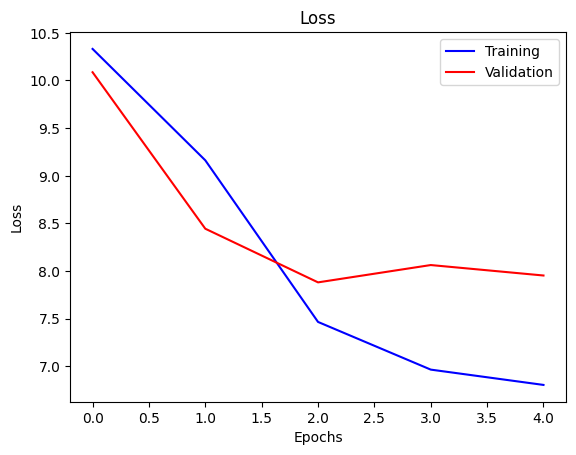

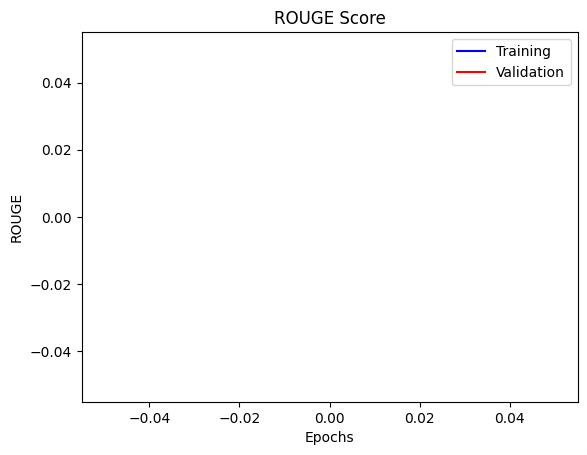

In [7]:
curves = ['curve_train_loss','curve_val_loss','curve_train_rouge','curve_val_rouge']
history = read_result(path, curves)

for c in history:
    list_value = history[c].strip('[]').split(', ')
    history[c] = [float(x) for x in list_value]

plot_curves(train_loss_history=history['curve_train_loss'], train_rouge_history=history['curve_train_rouge'],
            valid_loss_history=history['curve_val_loss'], valid_rouge_history=history['curve_val_rouge'], path=path)

### Model Prompting

# Modify the following to be able to query the model ad-hoc and/or at scale

# Load preprocessed training data
input_data = torch.load('../data/processed/tokenized_input_data.pt')
target_data = torch.load('../data/processed/tokenized_target_data.pt')
data = torch.cat((input_data, target_data), dim=1)
train_data, val_data, test_data = random_split(data, [0.8, 0.1, 0.1])

# Define data loaders
train_loader, val_loader, test_loader = dataloader(train_data, val_data, test_data, batch_size=param_values['batch_size'])

target, summary = summarize(model, test_loader)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

decoded_summaries = []
decoded_targets = []

summaries = summary.argmax(dim=-1).squeeze().transpose(0,1).tolist()
targets = target.squeeze(dim=0).transpose(0,1).tolist()
for i in range(len(summaries)): 
    summary_text = tokenizer.decode(summaries[i], skip_special_tokens=True)
    target_text = tokenizer.decode(targets[i], skip_special_tokens=True)

    decoded_summaries.append(summary_text)
    decoded_targets.append(target_text)

    print("Summary: ", summary_text)
    print("Target: ", target_text,'\n')